In [1]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
import json
from tqdm import tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from slugify import slugify

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.16.3
Wed Jun 19 10:52:21 2019 PDT

In [386]:
from google.cloud import bigquery

In [3]:
from dotenv import load_dotenv
load_dotenv('../../.env')

True

In [4]:
client = bigquery.Client()

_Note: source data is ~900k total lines_

# Long Term Campaign Value

## Read data

Since there's no userID in the Google Merch Store dataset, we'll assign random user IDs to each sessions.

### Read from `jsonl` (simulating `user_id`)

(array([3.82150e+05, 2.80622e+05, 1.53002e+05, 6.13260e+04, 1.81110e+04,
        4.06500e+03, 6.14000e+02, 1.00000e+02, 9.00000e+00, 1.00000e+00]),
 array([3.35422222e-02, 5.30268338e+01, 1.06020125e+02, 1.59013417e+02,
        2.12006708e+02, 2.65000000e+02, 3.17993292e+02, 3.70986583e+02,
        4.23979875e+02, 4.76973166e+02, 5.29966458e+02]),
 <a list of 10 Patch objects>)

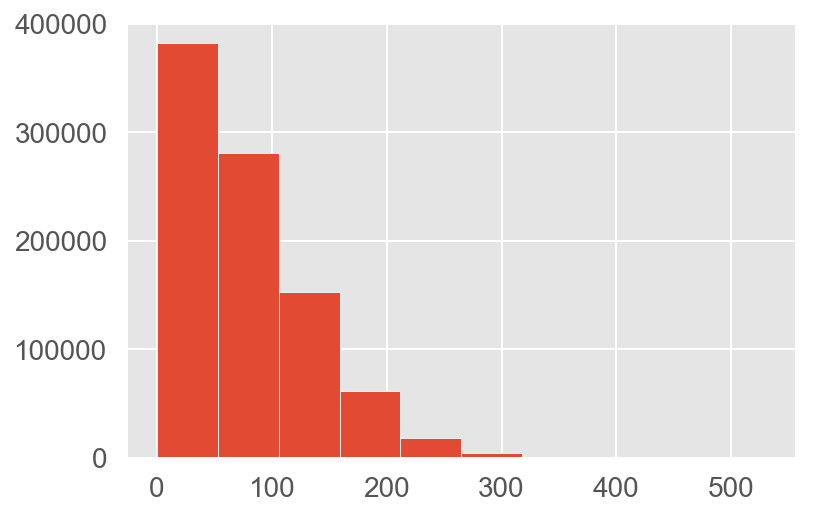

In [64]:
n = 1e5
p = 0.9
simulated_user_ids = np.random.binomial(n, p, int(9e5))
simulated_user_ids = np.abs(simulated_user_ids - simulated_user_ids.mean())
plt.hist(simulated_user_ids)

In [65]:
len(np.unique(simulated_user_ids))

804

In [157]:
width = 1e4
len(np.unique((np.random.exponential(scale=1, size=int(9e5)) * width).astype(int)))

50744

In [276]:
%%time
"""
Using local jsonl
"""
ERRORS = []

def pull_daily_data(verbose=False, raise_errors=False):
    dataset = sorted(glob.glob('../../data/raw/*.jsonl'))
    
    # Set random seed for simulated user ID
    np.random.seed(19)
    # Set user dilution. Higher means more users
    user_dilution = 1e5
    
    data = []
    user_id_dates = {}
    user_id_campaigns = {}
    for table in tqdm_notebook(dataset):
        if verbose:
            print('Scanning {}'.format(table))
        with open(table, 'r') as f:
            table_data = []
            for line in f:
                try:
                    d = json.loads(line)
                    simulated_user_id = int(np.random.exponential(scale=1) * user_dilution)
                    
                    if d['trafficSource']['campaign'] != '(not set)':
                        new_acquisition = True
                        date_acquired = d['date']
                        campaign_acquired = float('nan')
                        table_data.append([
                            d['date'],
                            d['userId'],
                            simulated_user_id,
                            d['trafficSource']['campaign'],
                            d['trafficSource']['source'],
                            d['trafficSource']['medium'],
                            d['totals']['transactions'],
                            d['totals']['totalTransactionRevenue'],
                            new_acquisition,
                            date_acquired,
                            campaign_acquired,
                        ])
                        user_id_dates[simulated_user_id] = d['date']
                        user_id_campaigns[simulated_user_id] = d['trafficSource']['campaign']

                    elif simulated_user_id in user_id_dates.keys():
                        new_acquisition = False
                        date_acquired = user_id_dates[simulated_user_id]
                        campaign_acquired = user_id_campaigns.get(simulated_user_id, float('nan'))
                        table_data.append([
                            d['date'],
                            d['userId'],
                            simulated_user_id,
                            d['trafficSource']['campaign'],
                            d['trafficSource']['source'],
                            d['trafficSource']['medium'],
                            d['totals']['transactions'],
                            d['totals']['totalTransactionRevenue'],
                            new_acquisition,
                            date_acquired,
                            campaign_acquired,
                        ])

                except Exception as e:
                    if verbose:
                        print('Error raised when reading row:\n{}'.format(e))
                    ERRORS.append([table, e])
                    if raise_errors:
                        raise(e)

            cols = ['date', 'userId', 'simulated_user_id', 'campaign', 'source', 'medium',
                    'transactions', 'totalTransactionRevenue', 'new_acquisition', 'date_acquired',
                   'campaign_acquired']
            if table_data:
                results = pd.DataFrame(table_data, columns=cols)
                data.append(results)

    df = pd.concat(data, ignore_index=True, sort=False)
    return df

CPU times: user 15 µs, sys: 25 µs, total: 40 µs
Wall time: 52.9 µs


In [277]:
# Cancel this execution after a few files have been parsed without error
jsonl_results = pull_daily_data(raise_errors=True, verbose=True)

Scanning ../../data/raw/ga_sessions_20160801.jsonl
Scanning ../../data/raw/ga_sessions_20160802.jsonl


KeyboardInterrupt: 

In [278]:
jsonl_results = pull_daily_data()

In [279]:
len(ERRORS), ERRORS[:10]

(0, [])

In [280]:
df = jsonl_results.copy()
df.date = pd.to_datetime(df.date)
df.date_acquired = pd.to_datetime(df.date_acquired)
df['first_acquisition_time_delta'] = df.date - df.date_acquired
df.to_csv('../../data/interim/long_term_campaign_value_simulated_userid_raw.csv', index=False)

In [281]:
def load_file(f_path):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    df = pd.read_csv(f_path)
    df.date = pd.to_datetime(df.date)
    df.date_acquired = pd.to_datetime(df.date_acquired)
    df['first_acquisition_time_delta'] = df.date - df.date_acquired
    return df

# Looking forward to walrus operator for stuff like this...
tmp = load_file('../../data/interim/long_term_campaign_value_simulated_userid_raw.csv')
if tmp is not None:
    print('Loading from file')
    df = tmp.copy()
    del tmp

Loading ../../data/interim/long_term_campaign_value_simulated_userid_raw.csv
Loading from file


In [282]:
df.head()

,date,userId,simulated_user_id,campaign,source,medium,transactions,totalTransactionRevenue,new_acquisition,date_acquired,campaign_acquired,first_acquisition_time_delta
0,2016-08-01,NaN,59587,AW - Electronics,google,cpc,NaN,NaN,True,2016-08-01,NaN,0 days
1,2016-08-01,NaN,48040,Data Share Promo,Partners,affiliate,NaN,NaN,True,2016-08-01,NaN,0 days
2,2016-08-01,NaN,7668,Data Share Promo,Partners,affiliate,NaN,NaN,True,2016-08-01,NaN,0 days
3,2016-08-01,NaN,43980,AW - Electronics,google,cpc,NaN,NaN,True,2016-08-01,NaN,0 days
4,2016-08-01,NaN,94201,AW - Electronics,google,cpc,NaN,NaN,True,2016-08-01,NaN,0 days


In [283]:
df.dtypes

date                             datetime64[ns]
userId                                  float64
simulated_user_id                         int64
campaign                                 object
source                                   object
medium                                   object
transactions                            float64
totalTransactionRevenue                 float64
new_acquisition                            bool
date_acquired                    datetime64[ns]
campaign_acquired                        object
first_acquisition_time_delta    timedelta64[ns]
dtype: object

In [284]:
len(df)

78911

In [285]:
(df.new_acquisition==False).sum()

50857

In [286]:
df.userId.isnull().sum() / len(df)

1.0

In [287]:
df.simulated_user_id.value_counts().head()

5652     20
1061     20
17177    20
8811     17
9310     17
Name: simulated_user_id, dtype: int64

In [288]:
df[df.simulated_user_id==5652]

,date,userId,simulated_user_id,campaign,source,medium,transactions,totalTransactionRevenue,new_acquisition,date_acquired,campaign_acquired,first_acquisition_time_delta
6623,2016-09-21,NaN,5652,Data Share Promo,Partners,affiliate,NaN,NaN,True,2016-09-21,NaN,0 days
6916,2016-09-24,NaN,5652,(not set),(direct),(none),NaN,NaN,False,2016-09-21,Data Share Promo,3 days
7332,2016-09-27,NaN,5652,(not set),(direct),(none),NaN,NaN,False,2016-09-21,Data Share Promo,6 days
9079,2016-10-12,NaN,5652,(not set),(direct),(none),NaN,NaN,False,2016-09-21,Data Share Promo,21 days
9817,2016-10-17,NaN,5652,(not set),youtube.com,referral,NaN,NaN,False,2016-09-21,Data Share Promo,26 days
18846,2016-12-04,NaN,5652,(not set),youtube.com,referral,NaN,NaN,False,2016-09-21,Data Share Promo,74 days
20731,2016-12-16,NaN,5652,(not set),(direct),(none),NaN,NaN,False,2016-09-21,Data Share Promo,86 days
21414,2016-12-20,NaN,5652,(not set),(direct),(none),NaN,NaN,False,2016-09-21,Data Share Promo,90 days
21822,2016-12-23,NaN,5652,(not set),google,organic,NaN,NaN,False,2016-09-21,Data Share Promo,93 days
26056,2017-01-23,NaN,5652,(not set),(direct),(none),NaN,NaN,False,2016-09-21,Data Share Promo,124 days


### Plotting results

Text(0,0.5,'Number of users')

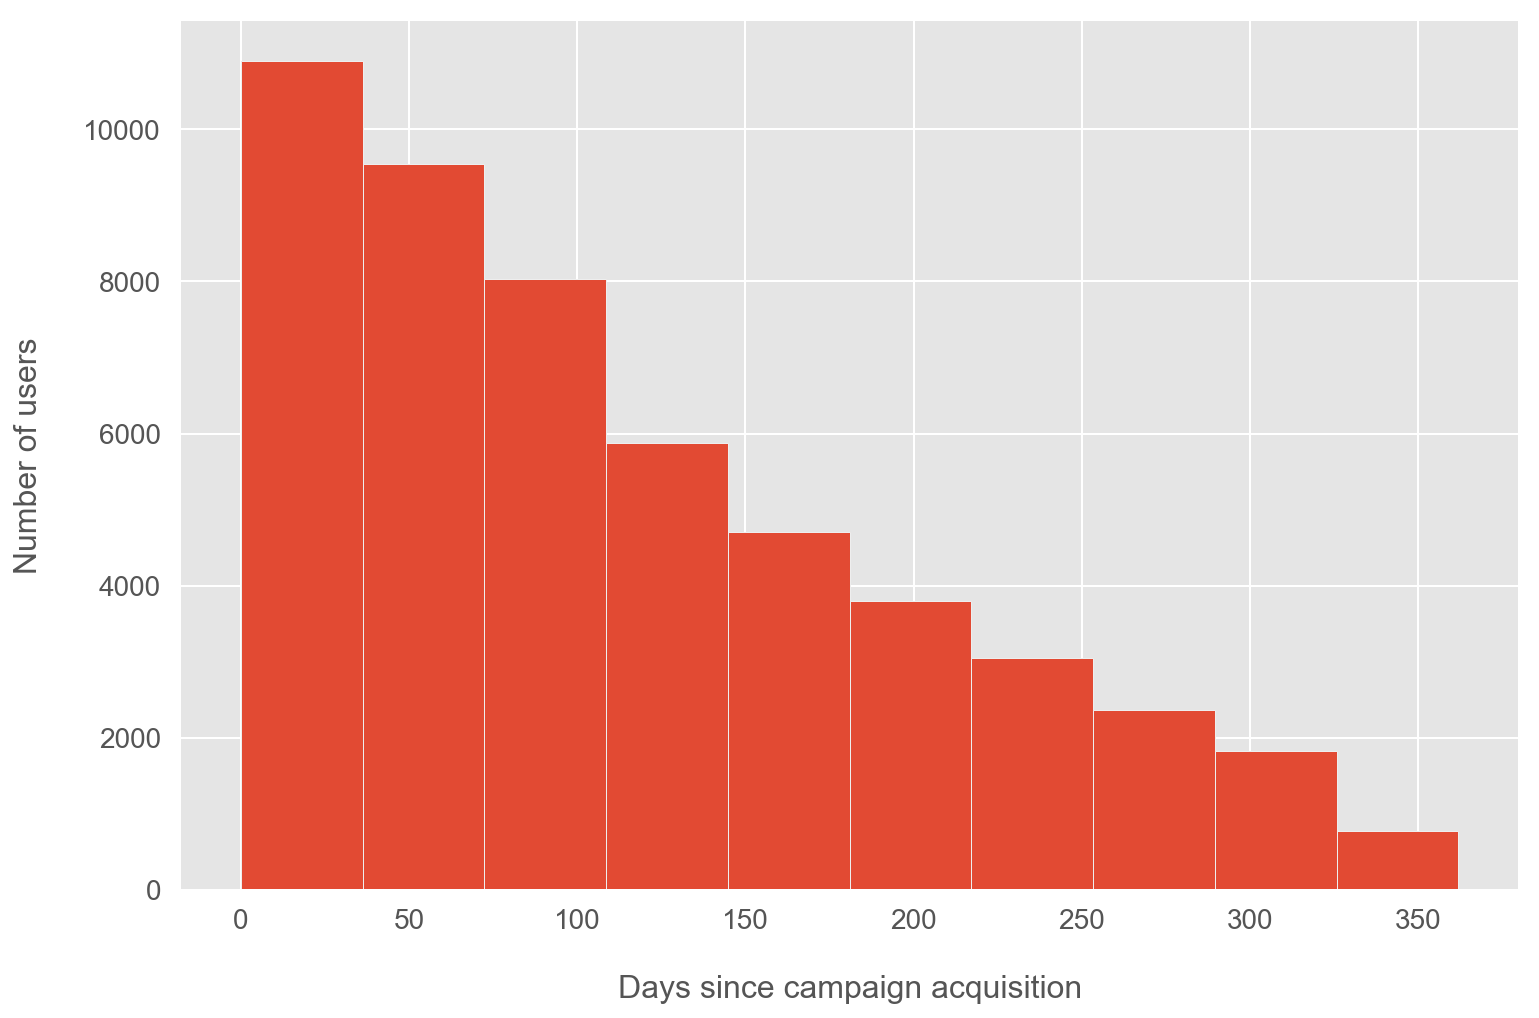

In [289]:
df[df.new_acquisition == False].first_acquisition_time_delta.astype('timedelta64[D]').plot.hist()
plt.xlabel('Days since campaign acquisition')
plt.ylabel('Number of users')

Text(0,0.5,'Number of cumulative sessions')

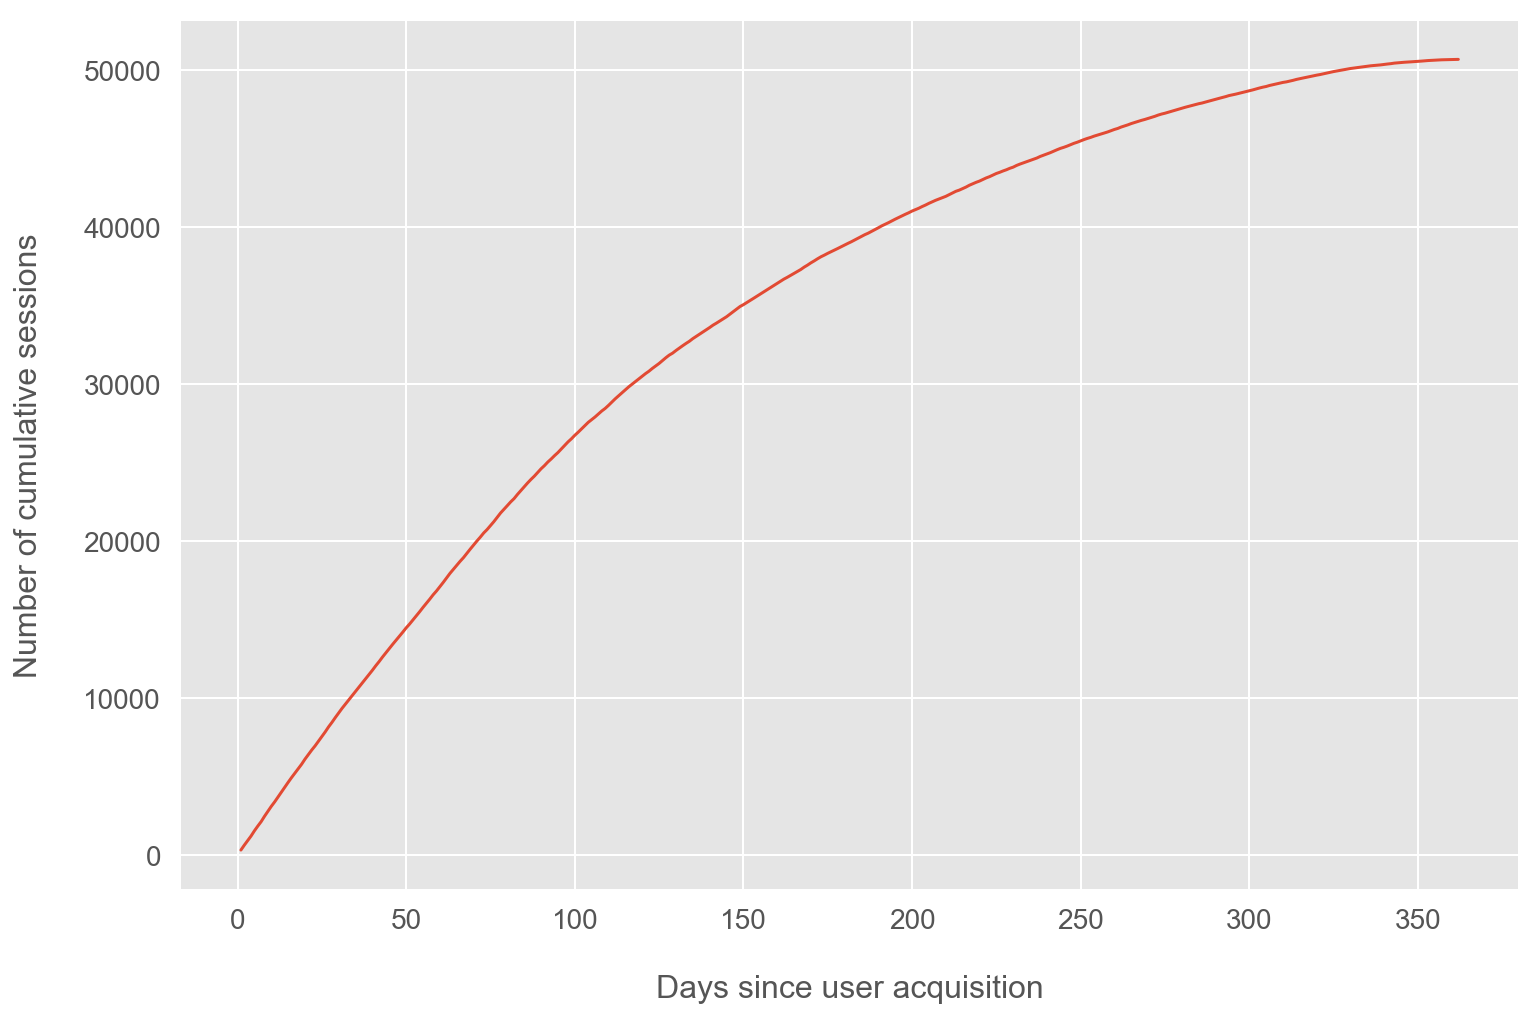

In [290]:
m = ~(df.new_acquisition)
s = df[m].first_acquisition_time_delta.astype('timedelta64[D]')
s = s[s>0]
s.value_counts().sort_index().cumsum().plot()
plt.xlabel('Days since user acquisition')
plt.ylabel('Number of cumulative sessions')

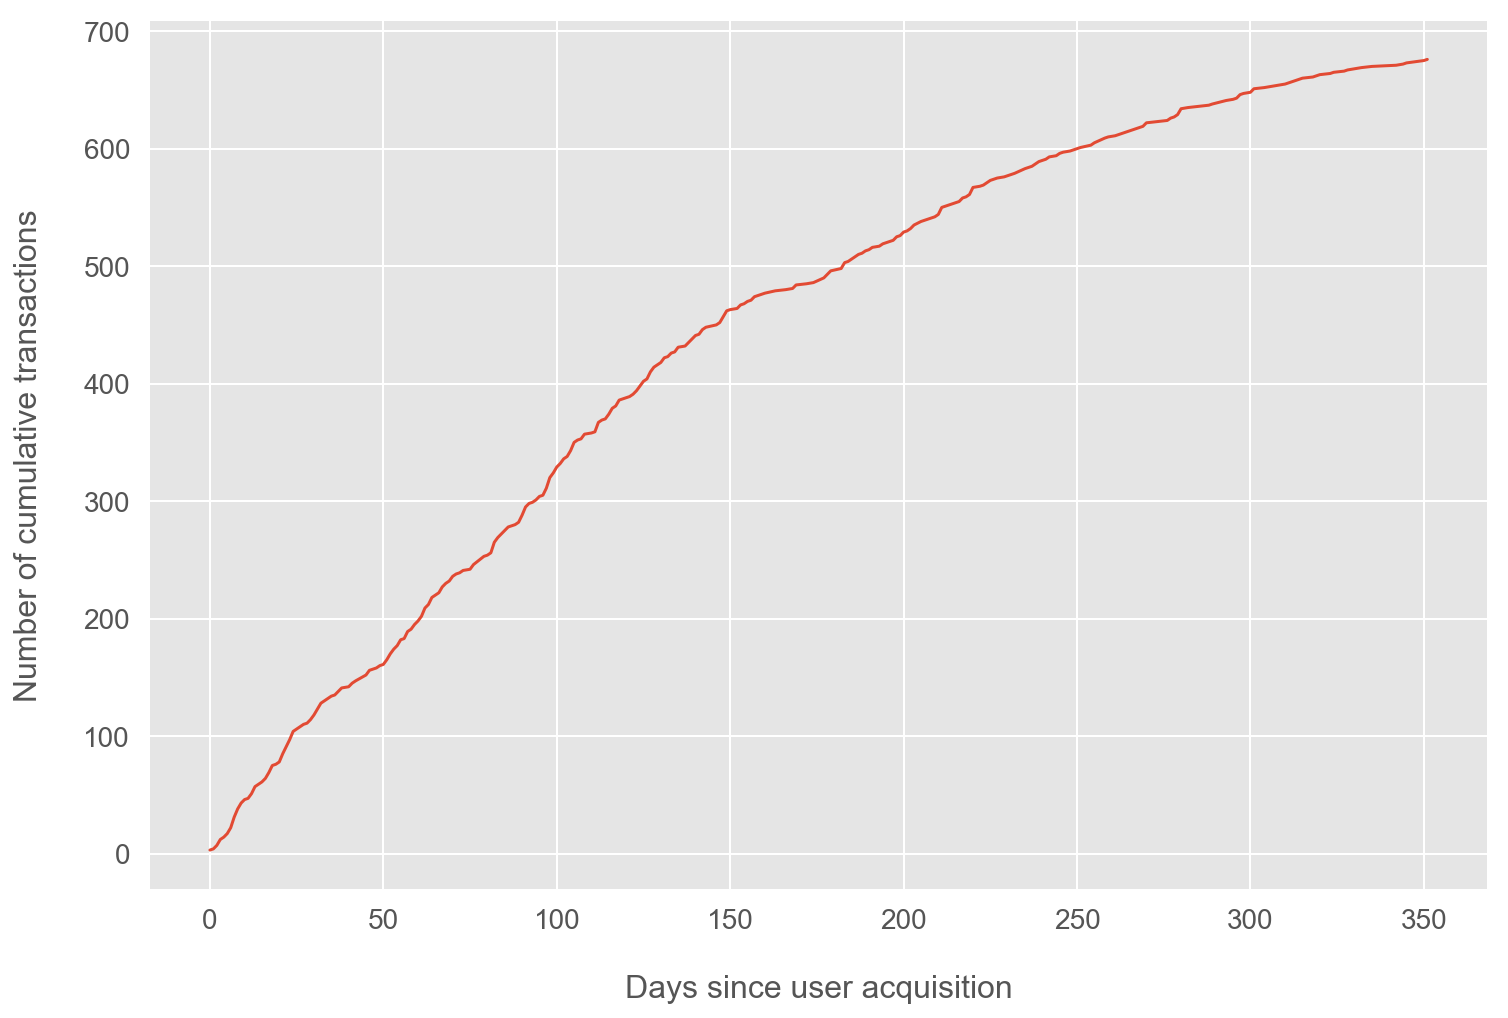

In [291]:
df_ = df.copy()
m = (~(df_.new_acquisition)) & (~(df_.transactions.isnull()))
df_.first_acquisition_time_delta = df_.first_acquisition_time_delta.astype('timedelta64[D]')
df_[m].groupby('first_acquisition_time_delta').transactions.sum().cumsum().plot()
plt.xlabel('Days since user acquisition')
plt.ylabel('Number of cumulative transactions')
del df_

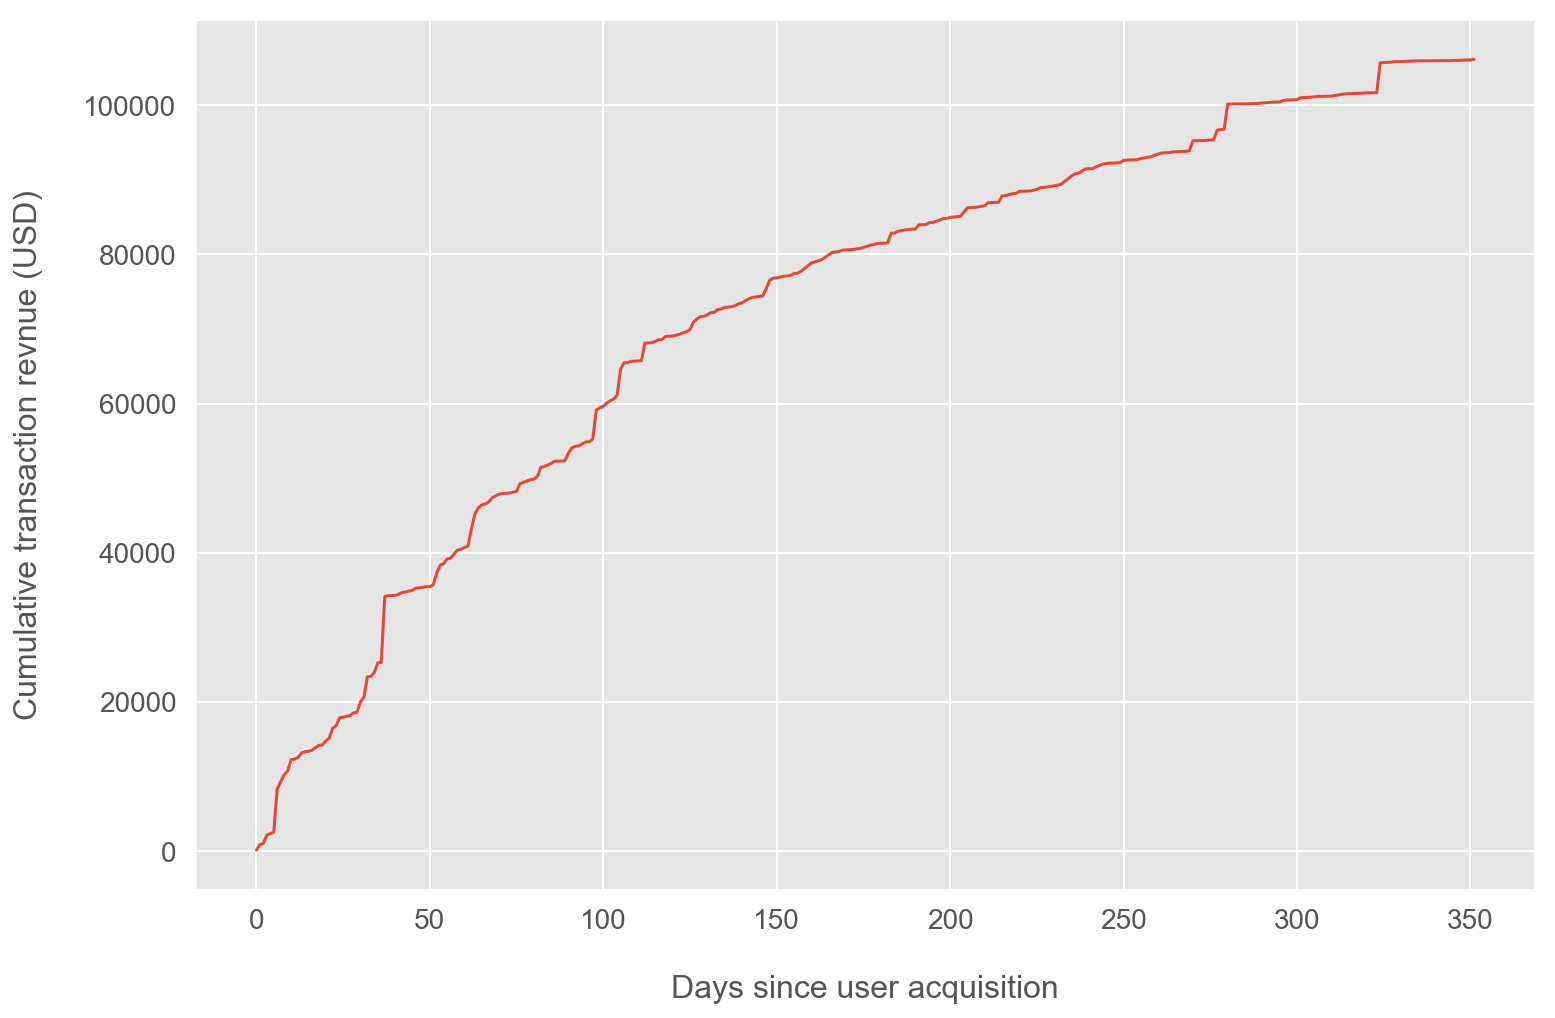

In [292]:
df_ = df.copy()
m = (~(df_.new_acquisition)) & (~(df_.totalTransactionRevenue.isnull()))
df_.first_acquisition_time_delta = df_.first_acquisition_time_delta.astype('timedelta64[D]')
(df_[m].groupby('first_acquisition_time_delta').totalTransactionRevenue.sum().cumsum() / 1e6).plot()
plt.xlabel('Days since user acquisition')
plt.ylabel('Cumulative transaction revnue (USD)')
del df_

In [293]:
top_campaigns = df.groupby('campaign').totalTransactionRevenue.sum().sort_values(ascending=False).index.tolist()

In [294]:
top_campaigns

['(not set)',
 'AW - Accessories',
 'AW - Dynamic Search Ads Whole Site',
 'Data Share Promo',
 'Data Share',
 'All Products',
 'AW - Electronics',
 'AW - Apparel']

In [303]:
top_campaigns = df[m].groupby('campaign_acquired').totalTransactionRevenue.sum().sort_values(ascending=False).index.tolist()

In [304]:
top_campaigns

['Data Share Promo',
 'AW - Dynamic Search Ads Whole Site',
 'AW - Accessories',
 'AW - Electronics',
 'All Products']

Hard code campaigns from above into call below

Found 414 samples for campaign: Data Share Promo
Found 168 samples for campaign: AW - Dynamic Search Ads Whole Site
Found 71 samples for campaign: AW - Accessories
Found 4 samples for campaign: AW - Electronics
Found 1 samples for campaign: All Products


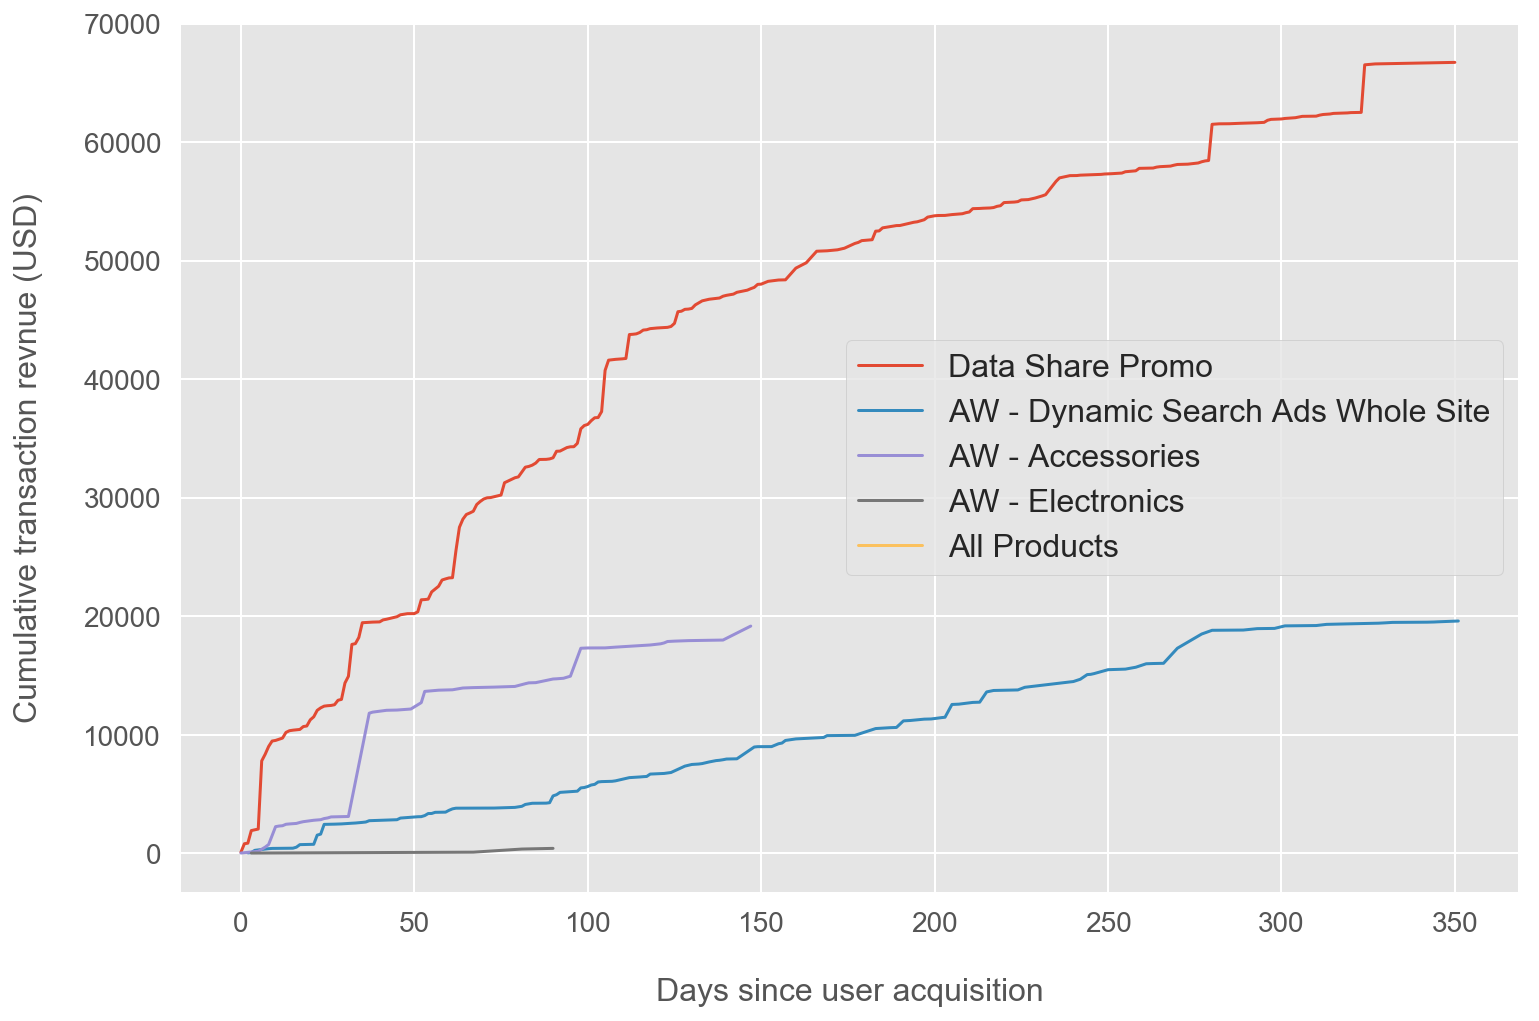

In [308]:
def plot_campaign_long_term_value(df, what, campaign, color=None):
    m_campaign = df.campaign_acquired == campaign
    num_samples = (m & m_campaign).sum()
    print('Found {} samples for campaign: {}'.format(num_samples, campaign))
    if num_samples == 0:
        print('Skipping')
        return

    plot_args = {'label': campaign}
    if color is not None:
        plot_args['color'] = color
    
    (df[m & m_campaign].groupby('first_acquisition_time_delta')[what].sum().cumsum() / 1e6)\
        .plot(**plot_args)
    plt.xlabel('Days since user acquisition')
    plt.ylabel('Cumulative transaction revnue (USD)')


df_ = df.copy()
# Filter on previously acquired users who made a transaction
m = (~(df_.new_acquisition)) & (~(df_.totalTransactionRevenue.isnull()))
df_.first_acquisition_time_delta = df_.first_acquisition_time_delta.astype('timedelta64[D]')

top_campaigns = [
    'Data Share Promo',
    'AW - Dynamic Search Ads Whole Site',
    'AW - Accessories',
    'AW - Electronics',
    'All Products'
]

for campaign in top_campaigns:
    plot_campaign_long_term_value(df_, what='totalTransactionRevenue', campaign=campaign)
    
plt.legend()
plt.xlabel('Days since user acquisition')
plt.ylabel('Cumulative transaction revnue (USD)')
plt.show()
del df_

In [297]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')